In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
from sklearn import preprocessing 


import pandas as pd
import numpy as np

pd.options.display.max_columns = None

import pandas as pd

# Cargar los dataframes desde los archivos subidos
fees_data = pd.read_csv('/kaggle/input/business-payment/extract - fees - data analyst - .csv')
cash_request_data = pd.read_csv('/kaggle/input/business-payment/extract - cash request - data analyst.csv')

# Convertir fechas a datetime (ignorar advertencias de zonas horarias)
fecha_cols_cr = ['send_at', 'cash_request_received_date', 'created_at']
fecha_cols_fees = ['created_at']

for col in fecha_cols_cr:
    cash_request_data[col] = pd.to_datetime(cash_request_data[col], errors='coerce')

for col in fecha_cols_fees:
    fees_data[col] = pd.to_datetime(fees_data[col], errors='coerce')

# Normalizar fechas faltantes en cash_request_data
cash_request_data['cash_request_received_date'] = cash_request_data.apply(
    lambda row: row['send_at'] + pd.DateOffset(days=3) if pd.isna(row['cash_request_received_date']) and row.get('status') == 'money_back' else row['cash_request_received_date'],
    axis=1
)

# Unir los dataframes usando cash_request_id de fees_data y id de cash_request_data
merged_data = pd.merge(cash_request_data, fees_data, left_on='id', right_on='cash_request_id', how='inner')

# Crear columna de periodo diario sin perder zonas horarias
merged_data['Mes_created_at_d'] = merged_data['created_at_x'].dt.strftime('%Y-%m-%d')

# Interpolar valores numéricos (evitar errores con valores no numéricos)
numeric_cols = ['amount', 'total_amount']
merged_data[numeric_cols] = merged_data[numeric_cols].apply(pd.to_numeric, errors='coerce')
ratio_merged = merged_data.groupby('Mes_created_at_d')[numeric_cols].mean().dropna()

# Limpiar todos los valores no numéricos en todas las columnas numéricas
for col in merged_data.select_dtypes(include=['float64', 'int64']).columns:
    merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce').fillna(0)

# Eliminar posibles infinitos
merged_data = merged_data.replace([float('inf'), float('-inf')], 0)

# Revisar nuevamente
merged_data.head()


/kaggle/input/business-payment/extract - fees - data analyst - .csv
/kaggle/input/business-payment/extract - cash request - data analyst.csv


,id_x,amount,status_x,created_at_x,updated_at_x,user_id,moderated_at,deleted_account_id,reimbursement_date,cash_request_received_date,money_back_date,transfer_type,send_at,recovery_status,reco_creation,reco_last_update,id_y,cash_request_id,type,status_y,category,total_amount,reason,created_at_y,updated_at_y,paid_at,from_date,to_date,charge_moment,Mes_created_at_d
0,23534,25.0,money_back,2020-10-23 15:20:26.163927+00:00,2020-12-18 13:08:29.099365+00,21465.0,NaN,0.0,2020-11-10 23:51:00+00,2020-10-26 15:21:26.878525+00:00,2020-11-06 07:16:21.845479+00,instant,2020-10-23 15:21:26.878525+00:00,NaN,NaN,NaN,16460,23534.0,instant_payment,accepted,NaN,5.0,Instant Payment Cash Request 23534,2020-10-23 15:21:35.895711+00:00,2020-10-23 15:21:35.89574+00,2020-11-06 07:16:22.014422+00,NaN,NaN,after,2020-10-23
1,2203,100.0,money_back,2020-05-27 02:26:27.615190+00:00,2020-06-09 11:25:51.72636+00,2109.0,2020-05-27 10:02:13.094467+00,0.0,2020-07-15 02:26:27+00,2020-05-29 00:00:00,2020-07-15 22:00:00+00,regular,NaT,NaN,NaN,NaN,100,2203.0,postpone,accepted,NaN,5.0,Postpone Cash Request 2203,2020-06-09 11:25:52.449808+00:00,2020-10-13 14:25:00.867548+00,NaN,2020-06-15 02:26:27+00,2020-07-15 02:26:27+00,before,2020-05-27
2,6098,100.0,active,2020-07-01 09:30:03.145410+00:00,2020-08-11 22:27:58.240406+00,23328.0,2020-07-01 16:44:53.070844+00,0.0,2020-08-03 22:00:00+00,2020-07-03 00:00:00,NaN,regular,NaT,pending,2020-08-11 22:27:55.367849+00,2020-08-11 22:27:58.255621+00,3733,6098.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 6098,2020-08-13 10:58:39.634220+00:00,2020-10-13 14:25:16.660127+00,NaN,2020-08-03 22:00:00+00,2020-09-03 10:58:32.274+00,after,2020-07-01
3,6098,100.0,active,2020-07-01 09:30:03.145410+00:00,2020-08-11 22:27:58.240406+00,23328.0,2020-07-01 16:44:53.070844+00,0.0,2020-08-03 22:00:00+00,2020-07-03 00:00:00,NaN,regular,NaT,pending,2020-08-11 22:27:55.367849+00,2020-08-11 22:27:58.255621+00,3734,6098.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 6098,2020-08-13 10:58:52.603153+00:00,2020-10-13 14:25:16.661371+00,NaN,2020-08-03 22:00:00+00,2020-09-03 10:58:32.274+00,after,2020-07-01
4,6098,100.0,active,2020-07-01 09:30:03.145410+00:00,2020-08-11 22:27:58.240406+00,23328.0,2020-07-01 16:44:53.070844+00,0.0,2020-08-03 22:00:00+00,2020-07-03 00:00:00,NaN,regular,NaT,pending,2020-08-11 22:27:55.367849+00,2020-08-11 22:27:58.255621+00,3735,6098.0,postpone,cancelled,NaN,5.0,Postpone Cash Request 6098,2020-08-13 11:00:39.879521+00:00,2020-10-13 14:25:16.662449+00,NaN,2020-08-03 22:00:00+00,2020-09-01 11:00:34.027+00,after,2020-07-01


In [3]:
# Corregir la agrupación a nivel mensual
merged_data['Mes_created_at_m'] = pd.to_datetime(merged_data['created_at_x']).dt.to_period('M').astype(str)

monthly_data_corrected = merged_data.groupby('Mes_created_at_m').agg(
    total_non_paid_fees=('total_amount', lambda x: x[merged_data.loc[x.index, 'status_x'].isin(['direct_debit_rejected', 'transaction_declined', 'canceled'])].sum()),
    total_confirmed_fees=('total_amount', lambda x: x[merged_data.loc[x.index, 'status_x'].isin(['direct_debit_sent'])].sum()),
    total_adelantos=('id_x', 
                     lambda ids: merged_data.loc[ids.index]
                     .drop_duplicates(subset='id_x')
                     .loc[merged_data.loc[ids.index, 'cash_request_received_date'].notna(), 'amount']
                     .sum()),
    total_fees=('total_amount', lambda x: x[merged_data.loc[x.index, 'status_x'] != 'canceled'].sum()),
    total_cr_non_reimbur=('amount', lambda x: x[
        (merged_data.loc[x.index, 'status_x'] != 'money_back') & 
        (merged_data.loc[x.index, 'status_x'] != 'active') & 
        (merged_data.loc[x.index, 'cash_request_received_date'].notnull())].sum())
).reset_index()

monthly_data_corrected.head(12)


<ipython-input-3-3d5b5e7f1d79>:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  merged_data['Mes_created_at_m'] = pd.to_datetime(merged_data['created_at_x']).dt.to_period('M').astype(str)


,Mes_created_at_m,total_non_paid_fees,total_confirmed_fees,total_adelantos,total_fees,total_cr_non_reimbur
0,2020-04,5.0,0.0,100.0,5.0,100.0
1,2020-05,105.0,0.0,9340.0,1285.0,2100.0
2,2020-06,1325.0,0.0,64633.0,8725.0,24040.0
3,2020-07,1800.0,35.0,78990.0,10395.0,33230.0
4,2020-08,1645.0,100.0,147726.0,17555.0,28465.0
5,2020-09,1945.0,55.0,216383.0,22920.0,31970.0
6,2020-10,2700.0,165.0,491071.0,43810.0,32435.0
7,2020-11,35.0,5.0,8635.0,565.0,450.0


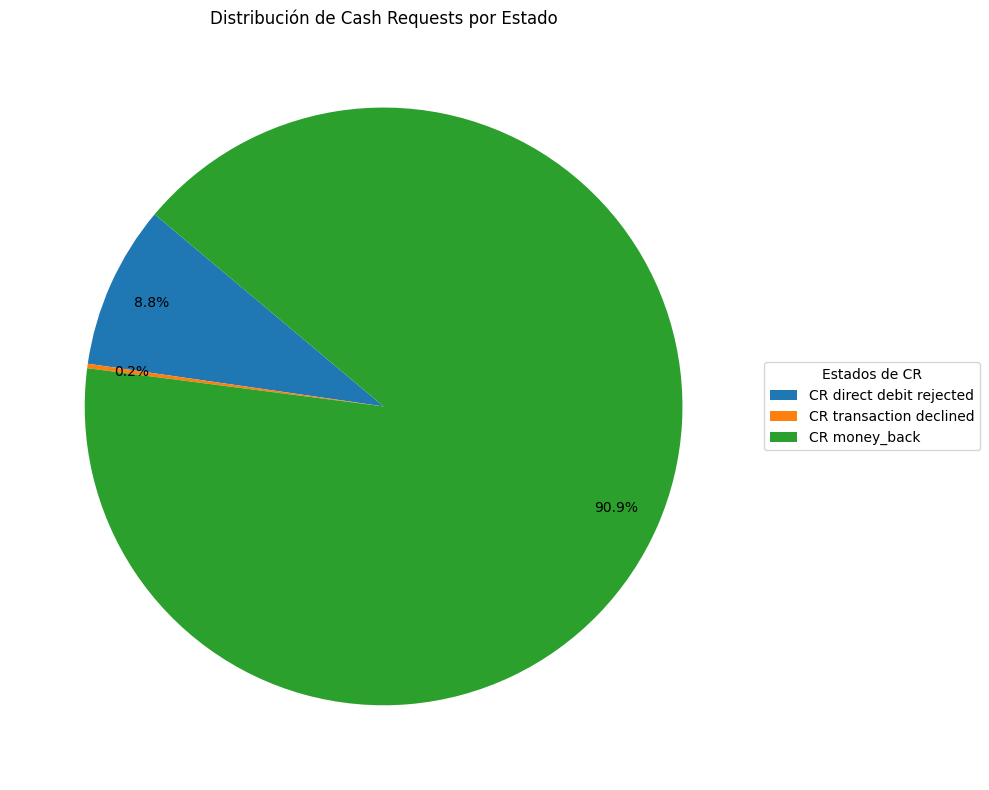

In [4]:
import matplotlib.pyplot as plt

# Calcular totales según los estados reales del dataset
total_direct_debit_rejected_cr = merged_data.loc[merged_data['status_x'] == 'direct_debit_rejected', 'amount'].sum()
total_transaction_declined_cr = merged_data.loc[merged_data['status_x'] == 'transaction_declined', 'amount'].sum()
total_money_back_cr = merged_data.loc[merged_data['status_x'] == 'money_back', 'amount'].sum()

# Definir etiquetas y tamaños
labels = ['CR direct debit rejected', 'CR transaction declined', 'CR money_back']
sizes = [total_direct_debit_rejected_cr, total_transaction_declined_cr, total_money_back_cr]

# Crear el gráfico de pastel
plt.figure(figsize=(10, 8))
plt.pie(
    sizes, 
    startangle=140, 
    autopct='%1.1f%%', 
    pctdistance=0.85
)

plt.title('Distribución de Cash Requests por Estado')
plt.legend(labels, title='Estados de CR', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10)
plt.tight_layout()
plt.show()


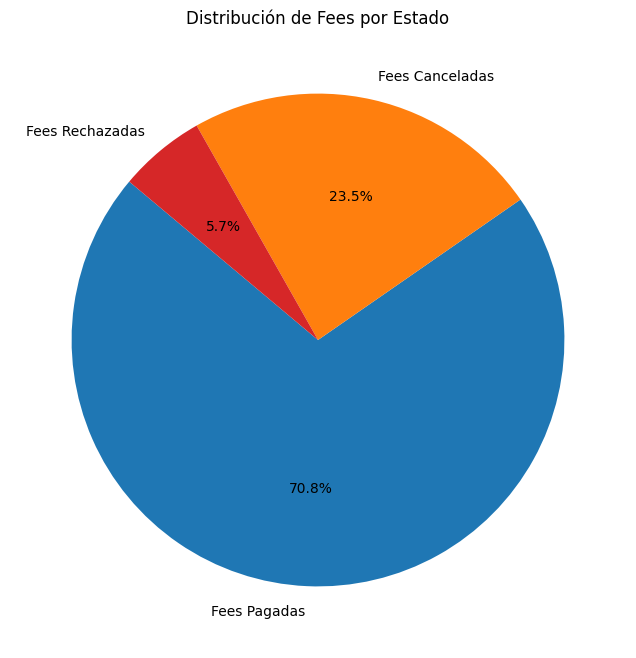

In [5]:
import matplotlib.pyplot as plt

# Calcular totales de fees en los datos originales
total_paid_fees = fees_data.loc[fees_data['status'] == 'accepted', 'total_amount'].sum()
total_cancelled_fees = fees_data.loc[fees_data['status'] == 'cancelled', 'total_amount'].sum()
total_rejected_fees = fees_data.loc[fees_data['status'] == 'rejected', 'total_amount'].sum()

# Etiquetas y tamaños
labels = ['Fees Pagadas', 'Fees Canceladas', 'Fees Rechazadas']
sizes = [total_paid_fees, total_cancelled_fees, total_rejected_fees]

# Crear gráfico de pastel
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=["#1f77b4", "#ff7f0e", "#d62728"], startangle=140, shadow=False)
plt.title('Distribución de Fees por Estado')
plt.show()


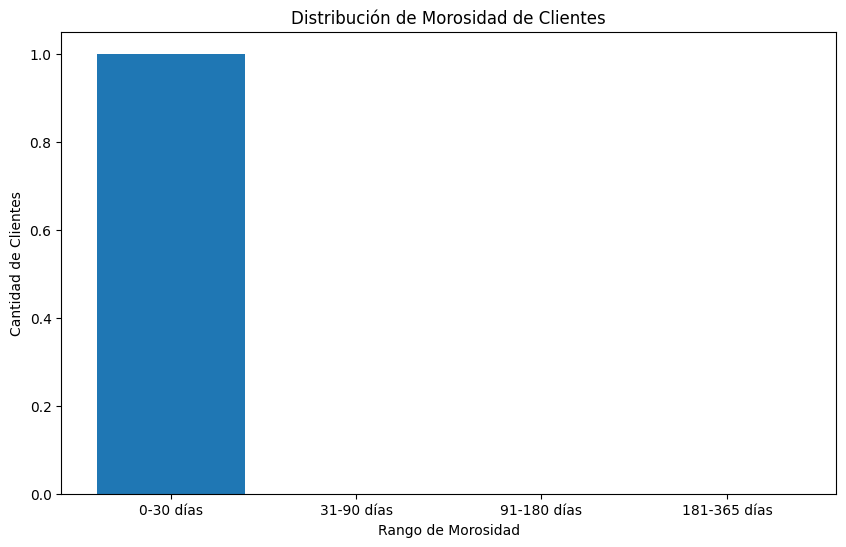

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir fechas a datetime
merged_data['reimbursement_date'] = pd.to_datetime(merged_data['reimbursement_date'], errors='coerce')
merged_data['cash_request_received_date'] = pd.to_datetime(merged_data['cash_request_received_date'], errors='coerce')

# Calcular los días de deuda
merged_data['days_to_reimbursement'] = (merged_data['reimbursement_date'] - merged_data['cash_request_received_date']).dt.days

# Crear rangos de morosidad
bins = [0, 30, 90, 180, 365]  # Hasta 365 días
labels = ['0-30 días', '31-90 días', '91-180 días', '181-365 días']

merged_data['rango_morosidad'] = pd.cut(merged_data['days_to_reimbursement'], bins=bins, labels=labels, right=False)

# Contar la cantidad de clientes en cada rango
morosidad_counts = merged_data['rango_morosidad'].value_counts().sort_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(morosidad_counts.index, morosidad_counts.values)
plt.xlabel('Rango de Morosidad')
plt.ylabel('Cantidad de Clientes')
plt.title('Distribución de Morosidad de Clientes')
plt.xticks(rotation=0)
plt.show()


In [7]:
# Calcular la deuda promedio por rango de morosidad
deuda_promedio_por_rango = merged_data.groupby('rango_morosidad')['days_to_reimbursement'].mean().reset_index()
deuda_promedio_por_rango.rename(columns={'days_to_reimbursement': 'dias_promedio_deuda'}, inplace=True)

# Mostrar el resultado
print(deuda_promedio_por_rango)



  rango_morosidad  dias_promedio_deuda
0       0-30 días                 15.0
1      31-90 días                  NaN
2     91-180 días                  NaN
3    181-365 días                  NaN


<ipython-input-7-896e26624779>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  deuda_promedio_por_rango = merged_data.groupby('rango_morosidad')['days_to_reimbursement'].mean().reset_index()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [8]:
# Calcular métricas mensuales para ver morosidad
cohort_risk_data = merged_data.groupby('Mes_created_at_m').agg(
    # Sumar los valores de 'total_amount' donde 'status_x' es igual a 'direct_debit_sent' (pagadas)
    total_paid_fees=('total_amount', lambda x: x[merged_data.loc[x.index, 'status_x'] == 'direct_debit_sent'].sum()),

    # Calcular total de fees que han sido confirmadas (para mantenerlo similar al código original)
    total_confirmed_fees=('total_amount', lambda x: x[merged_data.loc[x.index, 'status_x'] == 'direct_debit_sent'].sum()),

    # Calcular total de adelantos enviados (amount) donde 'cash_request_received_date' no es nulo
    total_adelantos=('amount', lambda x: merged_data.loc[x.index].drop_duplicates(subset='id_x').loc[merged_data.loc[x.index, 'cash_request_received_date'].notna(), 'amount'].sum()),

    # Calcular total de fees donde 'status_x' != 'canceled'
    total_fees=('total_amount', lambda x: x[merged_data.loc[x.index, 'status_x'] != 'canceled'].sum()),

    # Calcular total de amount de cash requests adelantados donde 'status_x' != 'money_back' y != 'active'
    total_cr_non_reimbur=('amount', lambda x: x[(merged_data.loc[x.index, 'status_x'] != 'money_back') & 
                                                (merged_data.loc[x.index, 'status_x'] != 'active') & 
                                                (merged_data.loc[x.index, 'cash_request_received_date'].notnull())].sum())
).reset_index()

# Calcular total de fees no pagadas
cohort_risk_data['total_non_paid_fees'] = cohort_risk_data['total_fees'] - cohort_risk_data['total_paid_fees']

# Calcular porcentaje de fees no pagadas
cohort_risk_data['non_paid_fees_percent'] = (cohort_risk_data['total_non_paid_fees'] / cohort_risk_data['total_fees'])

# Calcular porcentaje de cash requests no reembolsados
cohort_risk_data['non_paid_cr_percent'] = (cohort_risk_data['total_cr_non_reimbur'] / cohort_risk_data['total_adelantos'])

# Mostrar resultados
print(cohort_risk_data)


  Mes_created_at_m  total_paid_fees  total_confirmed_fees  total_adelantos  \
0          2020-04              0.0                   0.0              0.0   
1          2020-05              0.0                   0.0              0.0   
2          2020-06              0.0                   0.0              0.0   
3          2020-07             35.0                  35.0              0.0   
4          2020-08            100.0                 100.0              0.0   
5          2020-09             55.0                  55.0              0.0   
6          2020-10            165.0                 165.0             25.0   
7          2020-11              5.0                   5.0              0.0   

   total_fees  total_cr_non_reimbur  total_non_paid_fees  \
0         5.0                   0.0                  5.0   
1      1285.0                   0.0               1285.0   
2      8725.0                   0.0               8725.0   
3     10395.0                   0.0              10360.0 

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns


# Crear variable objetivo de morosidad (1 si tardó más de 30 días, 0 si no)
merged_data['days_to_reimbursement'] = (pd.to_datetime(merged_data['reimbursement_date']) - pd.to_datetime(merged_data['cash_request_received_date'])).dt.days
merged_data['morosidad'] = np.where(merged_data['days_to_reimbursement'] > 30, 1, 0)

# Selección de variables relevantes
features = ['amount', 'fees_amount', 'total_amount', 'client_id']
X = merged_data[features]
y = merged_data['morosidad']

# Normalizar datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División de datos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Modelos
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Métricas
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    
    results[name] = {'confusion_matrix': confusion, 'report': report, 'auc': auc, 'f1': f1}

    # Graficar matriz de confusión
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {name}')
    plt.xlabel('Predicción')
    plt.ylabel('Realidad')
    plt.show()

# Comparar modelos
for name, metrics in results.items():
    print(f"Modelo: {name}")
    print(f"AUC: {metrics['auc']:.4f}")
    print(f"F1-Score: {metrics['f1']:.4f}")
    print(metrics['report'])
    print("-"*50)


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


KeyError: "['fees_amount', 'client_id'] not in index"

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` p

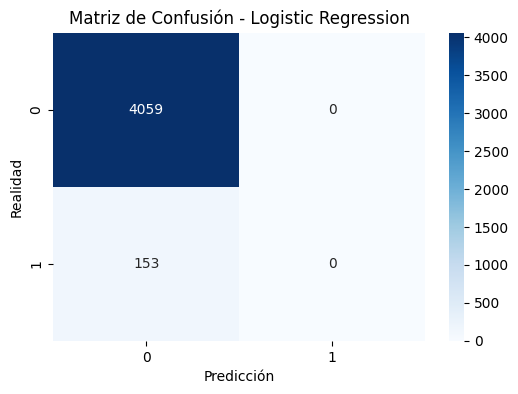

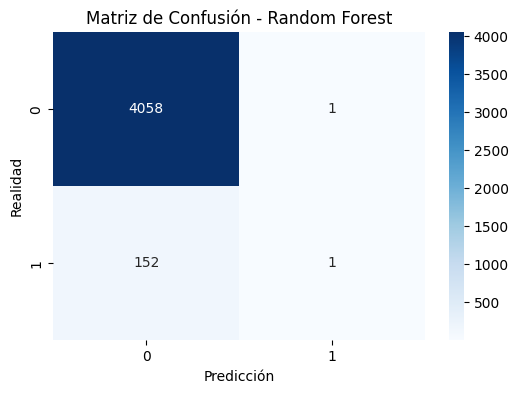

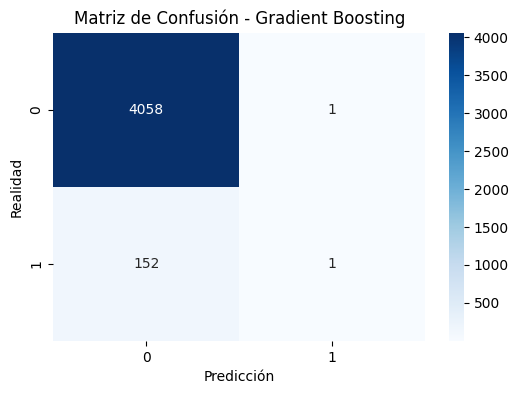

Modelo: Logistic Regression
AUC: 0.5892
F1-Score: 0.0000
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4059
           1       0.00      0.00      0.00       153

    accuracy                           0.96      4212
   macro avg       0.48      0.50      0.49      4212
weighted avg       0.93      0.96      0.95      4212

--------------------------------------------------
Modelo: Random Forest
AUC: 0.5922
F1-Score: 0.0129
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4059
           1       0.50      0.01      0.01       153

    accuracy                           0.96      4212
   macro avg       0.73      0.50      0.50      4212
weighted avg       0.95      0.96      0.95      4212

--------------------------------------------------
Modelo: Gradient Boosting
AUC: 0.5942
F1-Score: 0.0129
              precision    recall  f1-score   support

           0       0.96   

In [13]:
# Cargar datasets
fees_data = pd.read_csv('/kaggle/input/business-payment/extract - fees - data analyst - .csv')
cash_request_data = pd.read_csv('/kaggle/input/business-payment/extract - cash request - data analyst.csv')

# Convertir fechas a datetime, asegurando que todas sean tz-naive
fecha_cols = ['send_at', 'cash_request_received_date', 'reimbursement_date']
for col in fecha_cols:
    cash_request_data[col] = pd.to_datetime(cash_request_data[col], errors='coerce').dt.tz_localize(None)

fees_data['created_at'] = pd.to_datetime(fees_data['created_at'], errors='coerce').dt.tz_localize(None)

# Unir datasets
merged_data = pd.merge(cash_request_data, fees_data, left_on='id', right_on='cash_request_id', how='inner')

# Calcular días de deuda
merged_data['days_to_reimbursement'] = (merged_data['reimbursement_date'] - merged_data['cash_request_received_date']).dt.days
merged_data['morosidad'] = np.where(merged_data['days_to_reimbursement'] > 30, 1, 0)

# Selección de variables reales
features = ['amount', 'total_amount']
X = merged_data[features]
y = merged_data['morosidad']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

models = {'Logistic Regression': LogisticRegression(), 'Random Forest': RandomForestClassifier(), 'Gradient Boosting': GradientBoostingClassifier()}
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    results[name] = {'confusion_matrix': confusion, 'report': report, 'auc': auc, 'f1': f1}
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {name}')
    plt.xlabel('Predicción')
    plt.ylabel('Realidad')
    plt.show()

for name, metrics in results.items():
    print(f"Modelo: {name}")
    print(f"AUC: {metrics['auc']:.4f}")
    print(f"F1-Score: {metrics['f1']:.4f}")
    print(metrics['report'])
    print("-"*50)
